In [20]:
#@title  { vertical-output: true, form-width: "500px" }
import pandas as pd
import numpy as np
import seaborn as sns
import re
import sklearn.compose
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.preprocessing

# Ignorar errores de divergencias cuando alpha=0
import warnings
warnings.filterwarnings('ignore')

# Sort from lower to higher so that the lowest is 0 and the highest is n
def sortColumnByPriceAverage(X, columnName):
  companies = {}

  for product in X[columnName]:
    companies[product] = (0, 0)

  for i, company in enumerate(X[columnName]):
    price = X["Price"][i]
    val, n = companies[company]
    val += price

    companies[company] = (val, n+1)

  _companies = [ (company, companies[company][0]) for company in companies ]
  sortedCompanies = list(map(lambda t: t[0], sorted(_companies, key=lambda t: t[1])))

  return sortedCompanies

########################
# Handlers de columnas #
########################
def handle_Memoria(mem):
  regex_memoria = "(\d*\.?\d+)(\w+) (SSD|HDD|Flash Storage|Hybrid)" # Regex para identificar la memoria
  importancia = {
      "GB": 0.2, "TB": 20, # 0.2 euros por GB, 40 euros por TB
      "HDD": 0.5, "Flash Storage": 0.75, "Hybrid": 0.8, "SSD": 1 # Multiplicadores dependiendo del tipo de almacenamiento
  }

  productos = [ x for x in re.findall(regex_memoria, mem) ] # Lista con tuplas de todos los discos encontrados
  total = 0

  for producto in productos:
    m1 = int(float(producto[0]))  # Cantidad de memoria
    m2 = importancia[producto[1]] # Unidades
    m3 = importancia[producto[2]] # Tipo de disco
  
    total += m1**m2*m3 # Si, potencia. Es una potencia. Da menos error. ¯\_(ツ)_/¯
  
  return total

def handle_Resolucion(res):
  is_touchscreen = "Touchscreen" in res # Si es touchscreen o no
  is_ips = "IPS" in res # Si es IPS o no
  
  resolution = re.findall("\d+x\d+", res)[0]
  w, h = [ int(_) for _ in resolution.split("x") ] # Ancho y alto

  return (w*h)//10 + (is_ips*200) + (is_touchscreen*400)

# Solo para que este aqui
def handle_Cpu(cpu):
  ghz = float( cpu.split()[-1][:-3] )
  brand = 300 if "Intel" in cpu else 200 if "AMD" in cpu else 100
  
  return ghz*100+brand

# Solo para que este aqui
def handle_Gpu(gpu):
  return 3 if "Nvidia" in gpu else 2 if "AMD" in gpu else 1

#------------------------------------------------------------------------------------------------------#

##########
# Modelo #
##########
class Model:
  def __init__(self, alpha, ratio):
    self.TRAIN_URL = "https://filebin.net/3sw6utbuul0sh225/train.csv"
    self.TEST_URL  = "https://filebin.net/3sw6utbuul0sh225/test.csv"

    self.alpha = alpha
    self.ratio = ratio

    self.X = None
    self.Y = None
    self.X_T = None
    self.Y_T = None

    self.trained_model = None
    self.prediction = None
    self.csv = None

    self.outlier_func = None # La funcion para eliminar outliers (ej ElasticNet)

  ###########
  # Dataset #
  ###########
  def load_datasets(self):
    self.X = pd.read_csv(self.TRAIN_URL, sep=",")
    self.Y = pd.read_csv(self.TEST_URL,  sep=",")
    
    # Mantener una copia para echarle un vistazo
    self.X_original = self.X.copy(deep=True)
    self.Y_original = self.X.copy(deep=True)
  
  ##############################
  # Transformacion de columnas #
  ##############################
  # Aplica la funcion f a todos los elementos de una columna
  def map_column(self, columna, f):
    self.X[columna] = [ f(val) for val in self.X[columna] ]
    self.Y[columna] = [ f(val) for val in self.Y[columna] ]

  # Modifica los valores de cada columna. Se pueden comentar y no pasa nada.
  def modify_columns(self):
    # Listas auxiliares ordenadas por peso
    sortedCompanies = sortColumnByPriceAverage(self.X, "Company")
    sortedTypeNames = sortColumnByPriceAverage(self.X, "TypeName")
    sortedOS = ["No OS", "Linux", "Android", "Chrome OS", "Windows 10 S", "Windows 7", "Windows 10", "macOS", "Mac OS X"]

    self.map_column("Ram",              lambda val: int(val[:-2]))
    self.map_column("Weight",           lambda val: float(val[:-2]))            # Baja un poooooooooooco el error
    self.map_column("Company",          lambda val: sortedCompanies.index(val))
    self.map_column("TypeName",         lambda val: sortedTypeNames.index(val))
    self.map_column("OpSys",            lambda val: sortedOS.index(val))        # Comprobar sesgo
    self.map_column("Memory",           handle_Memoria)
    self.map_column("ScreenResolution", handle_Resolucion)                       # Baja el error muy poco
    self.map_column("Cpu",              handle_Cpu)                              # Baja el error menos de 10
    self.map_column("Gpu",              handle_Gpu)

  def transform_datasets(self):
    self.X_T = sklearn.compose.ColumnTransformer(transformers=[
        ("LaptopId",          "drop",                                 [0]),
        ("Company",           "passthrough",                          [1]), # probar drop
        ("Product",           "drop",                                 [2]),
        ("TypeName",          "passthrough",                          [3]), # probar drop
        ("Inches",            "passthrough",                          [4]),
        ("ScreenResolution",  sklearn.preprocessing.MinMaxScaler(),   [5]),
        ("Cpu",               "passthrough",                          [6]),
        ("Ram",               "passthrough",                          [7]),
        ("Memory",            "passthrough",   [8]),
        ("Gpu",               "passthrough",                          [9]),
        ("OpSys",             "passthrough",                          [10]),
        ("Weight",            "passthrough",                          [11]),
        ("Price",             "drop",                                 [12])
    ]).fit_transform(self.X)

    self.Y_T = sklearn.compose.ColumnTransformer(transformers=[
        ("LaptopId",          "drop",                                 [0]),
        ("Company",           "passthrough",                          [1]),
        ("Product",           "drop",                                 [2]),
        ("TypeName",          "passthrough",                          [3]),
        ("Inches",            "passthrough",                          [4]),
        ("ScreenResolution",  sklearn.preprocessing.MinMaxScaler(),   [5]),
        ("Cpu",               "passthrough",                          [6]),
        ("Ram",               "passthrough",                          [7]),
        ("Memory",            "passthrough",   [8]),
        ("Gpu",               "passthrough",                          [9]),
        ("OpSys",             "passthrough",                          [10]),
        ("Weight",            "passthrough",   [11])
    ]).fit_transform(self.Y)

    # StandardScaler. No cambia nada.
    self.X_T = sklearn.preprocessing.RobustScaler().fit_transform(self.X_T)
    self.Y_T = sklearn.preprocessing.RobustScaler().fit_transform(self.Y_T)
  
  ##########################
  # Regresion y prediccion #
  ##########################
  def set_outlier_func(self):
    #from random import randint
    #rand = randint(0, 1000)
    #print(rand)

    #
    # KNN baja el error 40 puntos.
    #

    #from sklearn.neighbors import KNeighborsRegressor
    #self.outlier_func = KNeighborsRegressor(n_neighbors=4)


    # Lo puede bajar alrededor de 4 puntos o asi
    #from sklearn.linear_model import SGDRegressor
    #self.outlier_func = SGDRegressor(max_iter=100, random_state=rand)

    #
    # RandomForest baja el error a 200 o asi.
    # rand=683 => -199
    #

    from sklearn.ensemble import RandomForestRegressor
    self.outlier_func = RandomForestRegressor(max_depth=100, random_state=683)

    #
    # ~-206
    #

    #from sklearn.ensemble import ExtraTreesRegressor
    #self.outlier_func = ExtraTreesRegressor(n_estimators=40)

    #self.outlier_func = ElasticNet(alpha=self.alpha, l1_ratio=self.ratio)

  def apply_regression(self):
    self.trained_model = self.outlier_func.fit(self.X_T, self.X["Price"])

  def predict(self):
    self.prediction = self.trained_model.predict(self.Y_T)

  #######
  # CSV #
  #######
  def to_csv(self):
    self.solucion = pd.DataFrame(data = {
        "LaptopId" : self.Y["LaptopId"],
        "Price"    : self.prediction
    })
  
  def save_csv(self, name):
    self.solucion.to_csv(name, index=False)

  #################
  # Ejecutar todo #
  #################
  def run(self):
    # Obtener y parsear datasets
    self.load_datasets()
    self.modify_columns()
    self.transform_datasets()

    # Aplicar regresion y hacer una prediccion
    self.set_outlier_func()
    self.apply_regression()
    self.predict()

    # Convertir a csv
    self.to_csv()
    self.save_csv("solucion.csv")
  
  def print_avgs(self):
    train_avg = sum(self.X["Price"]) / len(self.X["Price"])
    pred_avg  = sum(self.prediction) / len(self.prediction)

    print("Medias\n" + "-" * 100)
    print("Avg training set :", train_avg)
    print("Avg prediction   :", pred_avg)
    print("Diff             :", abs(train_avg - pred_avg), "\n")

############################
# Clase para probar el MAE #
############################
class ModelTest(Model):
  def __init__(self, alpha, ratio, partition_n):
    # Inicializar padre. Tiene que ser la primera llamada dentro del __init__
    super().__init__(alpha, ratio) 

    self.PARTITION_N = partition_n # Numero de particiones que se van a probar
    self.maes = None               # Array con los maes de cada intento

  def get_maes(self):
    # Prueba n particiones para training y validacion y devuelve el error obtenido en cada intento
    self.maes = cross_val_score(self.outlier_func, self.X_T, self.X["Price"],
                                cv=self.PARTITION_N, scoring="neg_mean_absolute_error")

  def run(self):
    self.load_datasets()
    self.modify_columns()
    self.transform_datasets()
    self.set_outlier_func()
    self.get_maes()

  def print_MAE(self):
    print("MAEs   :", self.maes)
    print("MAE avg:", sum(self.maes) / len(self.maes))

def main():
  es_prueba = False   #@param {type:"boolean"}
  alpha = 0          #@param {type:"raw"}
  ratio = 0          #@param {type:"raw"}
  partition_n = 5    #@param {type:"slider", min:0, max:10,  step:1}

  if es_prueba:
    # Ejecutar para hacer pruebas
    model_test = ModelTest(alpha=alpha, ratio=ratio, partition_n=partition_n)
    model_test.run()
    model_test.print_MAE()

    return model_test

  else:
    # Ejecutar para guardar el resultado
    model = Model(alpha=alpha, ratio=ratio)
  
    model.run()
    model.print_avgs()

    return model

model = main()


Medias
----------------------------------------------------------------------------------------------------
Avg training set : 1130.0370065789475
Avg prediction   : 1092.311247438396
Diff             : 37.72575914055142 



In [ ]:
model.X

,LaptopId,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,981,13,Portege Z30-C-1CV,5,13.3,20736.0,Intel Core i5 6200U 2.3GHz,4,512,Intel HD Graphics 520,4,1.2kg,1195.00
1,996,16,Spectre 13-V111dx,3,13.3,20936.0,Intel Core i7 7500U 2.7GHz,8,1024,Intel HD Graphics 620,6,1.11kg,1349.00
2,77,18,Inspiron 5570,5,15.6,20736.0,Intel Core i7 8550U 1.8GHz,8,514,Intel UHD Graphics 620,6,2.02kg,855.00
3,103,16,Envy 13-ad009n,3,13.3,20836.0,Intel Core i7 7500U 2.7GHz,8,1024,Nvidia GeForce MX150,6,1.38kg,1119.00
4,946,18,Latitude 7280,3,12.5,20836.0,Intel Core i5 7200U 2.5GHz,8,1024,Intel HD Graphics,6,1.36kg,1472.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,994,18,Inspiron 5378,2,13.3,20836.0,Intel Core i5 7200U 2.5GHz,8,1024,Intel HD Graphics 620,6,1.68kg,889.00
908,615,15,FX753VD-GC007T (i7-7700HQ/8GB/1TB,4,17.3,20736.0,Intel Core i7 7700HQ 2.8GHz,8,514,Nvidia GeForce GTX 1050,6,3kg,1168.00
909,1063,18,Inspiron 5567,5,15.6,20736.0,Intel Core i7 7500U 2.7GHz,16,4,AMD Radeon R7 M445,6,2.32kg,989.99
910,96,18,Inspiron 3567,5,15.6,20736.0,Intel Core i7 7500U 2.7GHz,8,2,AMD Radeon R5 M430,1,2.2kg,599.90


In [ ]:
def sortCompaniesByPriceAverage(model):
  companies = {}

  for product in model.X["Company"]:
    companies[product] = (0, 0)

  for i, company in enumerate(model.X["Company"]):
    price = model.X["Price"][i]
    val, n = companies[company]
    val += price

    companies[company] = (val, n+1)

  _companies = [ (company, companies[company][0]) for company in companies ]
  sortedCompanies = list(map(lambda t: t[0], sorted(_companies, key=lambda t: -t[1])))

  return sortedCompanies

sortCompaniesByPriceAverage(model)


['Dell',
 'Lenovo',
 'HP',
 'Asus',
 'MSI',
 'Toshiba',
 'Acer',
 'Razer',
 'Apple',
 'Microsoft',
 'Samsung',
 'LG',
 'Google',
 'Xiaomi',
 'Huawei',
 'Fujitsu',
 'Mediacom',
 'Vero',
 'Chuwi']

In [ ]:
model.X

,LaptopId,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,981,13,Portege Z30-C-1CV,5,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4,128GB SSD,Intel HD Graphics 520,4,1.2kg,1195.00
1,996,16,Spectre 13-V111dx,3,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,8,256GB SSD,Intel HD Graphics 620,6,1.11kg,1349.00
2,77,18,Inspiron 5570,5,15.6,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8,128GB SSD + 1TB HDD,Intel UHD Graphics 620,6,2.02kg,855.00
3,103,16,Envy 13-ad009n,3,13.3,IPS Panel Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8,256GB SSD,Nvidia GeForce MX150,6,1.38kg,1119.00
4,946,18,Latitude 7280,3,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics,6,1.36kg,1472.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,994,18,Inspiron 5378,2,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,6,1.68kg,889.00
908,615,15,FX753VD-GC007T (i7-7700HQ/8GB/1TB,4,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050,6,3kg,1168.00
909,1063,18,Inspiron 5567,5,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16,2TB HDD,AMD Radeon R7 M445,6,2.32kg,989.99
910,96,18,Inspiron 3567,5,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8,1TB HDD,AMD Radeon R5 M430,1,2.2kg,599.90


In [ ]:
set(model.X["Gpu"])

{'AMD FirePro W4190M ',
 'AMD FirePro W5130M',
 'AMD R4 Graphics',
 'AMD Radeon 520',
 'AMD Radeon 530',
 'AMD Radeon 540',
 'AMD Radeon R2',
 'AMD Radeon R2 Graphics',
 'AMD Radeon R3',
 'AMD Radeon R4',
 'AMD Radeon R4 Graphics',
 'AMD Radeon R5',
 'AMD Radeon R5 430',
 'AMD Radeon R5 520',
 'AMD Radeon R5 M330',
 'AMD Radeon R5 M420',
 'AMD Radeon R5 M420X',
 'AMD Radeon R5 M430',
 'AMD Radeon R7',
 'AMD Radeon R7 Graphics',
 'AMD Radeon R7 M440',
 'AMD Radeon R7 M445',
 'AMD Radeon R7 M460',
 'AMD Radeon R7 M465',
 'AMD Radeon R9 M385',
 'AMD Radeon RX 540',
 'AMD Radeon RX 550',
 'AMD Radeon RX 560',
 'AMD Radeon RX 580',
 'ARM Mali T860 MP4',
 'Intel Graphics 620',
 'Intel HD Graphics',
 'Intel HD Graphics 400',
 'Intel HD Graphics 405',
 'Intel HD Graphics 500',
 'Intel HD Graphics 505',
 'Intel HD Graphics 510',
 'Intel HD Graphics 515',
 'Intel HD Graphics 520',
 'Intel HD Graphics 5300',
 'Intel HD Graphics 540',
 'Intel HD Graphics 6000',
 'Intel HD Graphics 615',
 'Intel HD

In [ ]:
def precioMemoria(producto):
  m1 = float(producto[0])
  m2 = ["_", "GB", "TB"].index(producto[1])
  m3 = ["_", "HDD", "SSD", "Hybrid", "Flash Storage"].index(producto[2])
  
  return m1*m2*m3

memory = set(model.X["Memory"])
regex = "(\d*\.?\d+)(\w+) (SSD|HDD|Flash Storage|Hybrid)"

memoryFound = [ sum([ precioMemoria(x) for x in re.findall(regex, mem)]) for mem in memory ]
memoryFound
# x TB HDD
# x GB HDD
# x GB SSD
# x TB Hybrid
# x GB Flash Storage
# y + z
# 

[1524.0,
 518.0,
 64.0,
 514.0,
 1024.0,
 260.0,
 480.0,
 128.0,
 6.0,
 516.0,
 256.0,
 1024.0,
 2.0,
 1012.0,
 1028.0,
 512.0,
 128.0,
 128.0,
 2.0,
 256.0,
 2048.0,
 1024.0,
 6.0,
 500.0,
 512.0,
 258.0,
 4.0,
 4.0,
 2048.0,
 360.0,
 64.0,
 32.0,
 1026.0]

In [ ]:
set(model.X["Cpu"])
#1x2
# 4K Ultra HD / Touchscreen 1x2
# 

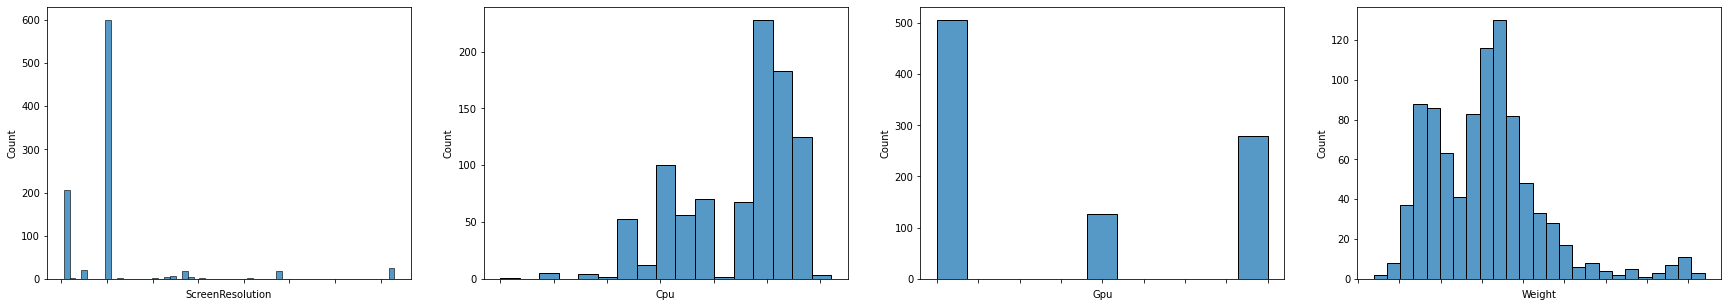

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Relplot
# Scatterplot
# Density plot
# Characteristic line plot

class Draw:
  def __init__(self, model):
    self.model = model
    self.labels = ["Company", "Product", "TypeName", "Inches", "ScreenResolution", "Cpu", "Ram", "Memory", "Gpu", "OpSys", "Weight"]

  def get_grid(self, cols, rows, h, w):
      return plt.subplots(rows, cols, figsize=(w, h))

  def histogram(self, labels):
    fig0, axs0 = plt.subplots(ncols=4)
    fig0.set_figwidth(30)
    fig0.set_figheight(5)

    for i, label in enumerate(labels):
      aux = sns.histplot(self.model.X[label], ax=axs0[i])

      aux.set_xticklabels(aux.get_xticklabels(), rotation = 80, horizontalalignment = 'right')

    #plt.show()

  def countplot(self, labels):
    fig0, axs0 = plt.subplots(ncols=4)
    fig0.set_figwidth(30)
    fig0.set_figheight(5)

    for i, label in enumerate(labels):
      aux = sns.countplot(self.model.X[label], ax=axs0[i])

      #aux0.set_xticklabels(aux0.get_xticklabels(), rotation = 85, horizontalalignment = 'right')

      aux.set(xticklabels=label)
      aux.set(xlabel=None)

  def kde(self, labels):
    # El numero de caracteristicas que tienen tipo numerico, para decidir las dimensiones
    n_of_numerical_features = len([ True for f in self.model.X if type(self.model.X[f][0]) != str ])
    
    fig, axs = self.get_grid(rows=n_of_numerical_features//4, cols=4, h=10, w=25)
    fig.delaxes(axs[1][2]) # Elimnar plots vacios
    fig.delaxes(axs[1][3])
    
    i = 0
    for label in labels:
      if type(self.model.X[label][0]) != str:
        sns.kdeplot(self.model.X[label], ax=axs[i//4, i%4])
        i += 1
  
  def relplot(self, labels, hue=None):
    fig, axs = self.get_grid(rows=3, cols=4, h=15, w=30)
    fig.delaxes(axs[2][3]) # Elimnar plots vacios

    for i, label in enumerate(labels):
      s = sns.scatterplot(data=self.model.X, x=label, y="Price", ax=axs[i//4, i%4], hue=hue)

      # Si es una feature con strings, quitar los ticks porque si no no se ve nada
      if type(self.model.X[label][0]) == str:
        s.set(xticklabels=[])  
        s.tick_params(bottom=False)

  def run(self):
    #self.countplot(["ScreenResolution", "Cpu", "Gpu", "Weight"])
    #self.histogram(["ScreenResolution", "Cpu", "Gpu", "Weight"])
    #self.kde(self.labels)
    self.relplot(self.labels, hue="TypeName")

    #plt.show()

  
draw = Draw(model)
draw.run()

In [ ]:
model.X

,LaptopId,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,981,13,Portege Z30-C-1CV,5,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4,512,Intel HD Graphics 520,4,1.2kg,1195.00
1,996,16,Spectre 13-V111dx,3,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,8,1024,Intel HD Graphics 620,6,1.11kg,1349.00
2,77,18,Inspiron 5570,5,15.6,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8,514,Intel UHD Graphics 620,6,2.02kg,855.00
3,103,16,Envy 13-ad009n,3,13.3,IPS Panel Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8,1024,Nvidia GeForce MX150,6,1.38kg,1119.00
4,946,18,Latitude 7280,3,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8,1024,Intel HD Graphics,6,1.36kg,1472.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,994,18,Inspiron 5378,2,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8,1024,Intel HD Graphics 620,6,1.68kg,889.00
908,615,15,FX753VD-GC007T (i7-7700HQ/8GB/1TB,4,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8,514,Nvidia GeForce GTX 1050,6,3kg,1168.00
909,1063,18,Inspiron 5567,5,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16,4,AMD Radeon R7 M445,6,2.32kg,989.99
910,96,18,Inspiron 3567,5,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8,2,AMD Radeon R5 M430,1,2.2kg,599.90
